In [ ]:
!pip -q install pandas scikit-learn tqdm


import os, json, math, random
from pathlib import Path
from typing import List, Dict, Optional
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, classification_report

import cv2

In [ ]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATA_ROOTS = [
    "/kaggle/input/soccernet/england_epl",
]
SEASONS = ["2014-2015", "2015-2016", "2016-2017"]

CLASS_LABELS = [
    "Ball out of play",
    "Throw-in",
    "Foul",
    "Indirect free-kick",
    "Clearance",
    "Shots on target",
    "Shots off target",
    "Corner",
]
LABEL2ID = {c:i for i,c in enumerate(CLASS_LABELS)}

# Filtrado de visibilidad (categórica en SoccerNet)
VISIBILITY_KEEP_SET = {"visible"}  

# Ventanas asimétricas por clase (en segundos, relativas al position_ms)
WINDOWS_S = {
    "Ball out of play":   (-1.0,  1.0),
    "Throw-in":           (-0.8,  1.2),
    "Foul":               (-1.2,  0.8),
    "Indirect free-kick": (-1.0,  1.0),
    "Clearance":          (-1.0,  1.0),
    "Shots on target":    (-0.5,  1.5),
    "Shots off target":   (-1.2,  0.8),
    "Corner":             (-1.2,  0.8),
}
# Guard bands (s) para resolver solapes
GUARD_BAND_S = {
    "Ball out of play":   (0.6, 0.6),
    "Throw-in":           (0.2, 1.0),
    "Foul":               (0.8, 0.8),
    "Indirect free-kick": (0.6, 0.6),
    "Clearance":          (0.8, 0.8),
    "Shots on target":    (0.4, 0.8),
    "Shots off target":   (0.8, 0.8),
    "Corner":             (0.8, 0.8),
}

PRIORITY = {
    "Shots on target":     8,
    "Corner":              7,
    "Foul":                6,
    "Shots off target":    5,
    "Indirect free-kick":  4,
    "Throw-in":            3,
    "Clearance":           2,
    "Ball out of play":    1,
}
MIN_KEEP_RATIO = 0.7  # mínimo % de ventana original al recortar por solapes

# Contrato del clip (input del modelo)
T = 16               # frames por clip
FPS_TARGET = 10.0    # fps efectivos dentro del clip
L_SEC = T / FPS_TARGET
SIDE_SHORT = 256     # resize por lado corto
H = W = 112          # crop final

def sec_to_ms(s): return int(round(1000*s))

def probe_video(path):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise RuntimeError(f"No se pudo abrir video: {path}")
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    dur_ms = int(round(1000.0 * n / fps))
    cap.release()
    return n, fps, dur_ms

def _parse_half_from_gameTime(gt: str) -> Optional[int]:
    if not isinstance(gt, str): return None
    try:
        h = int(gt.split("-")[0].strip())
        return h if h in (1,2) else None
    except:
        return None

def load_labels(path):
    with open(path, "r") as f:
        data = json.load(f)

    if isinstance(data, dict) and "events" in data:
        events = data["events"]
    elif isinstance(data, list):
        events = data
    else:
        events = data.get("annotations", []) if isinstance(data, dict) else []

    out = []
    for e in events:
        pos_str = e.get("position_ms", e.get("position", e.get("time_ms")))
        if pos_str is None: 
            continue
        try:
            position_ms = int(str(pos_str).strip())
        except:
            continue

        label = e.get("label", e.get("event", ""))
        if not label:
            continue

        vis = str(e.get("visibility","")).lower().strip()
        half_val = e.get("half", e.get("period", None))
        half = None
        if half_val is not None and str(half_val).isdigit():
            half = int(half_val) if int(half_val) in (1,2) else None
        if half is None:
            half = _parse_half_from_gameTime(e.get("gameTime", None))

        out.append({
            "position_ms": position_ms,
            "label": label,
            "visibility": vis,
            "half": half
        })
    return out

# Acepta partidos con una o ambas mitades
def find_match_folders_anyhalf(roots, seasons):
    matches = []
    for root in roots:
        for season in seasons:
            season_dir = Path(root)/season
            if not season_dir.exists():
                continue
            for match_dir in season_dir.rglob("*"):
                if not match_dir.is_dir():
                    continue
                lab = match_dir/"Labels-v2.json"
                v1  = match_dir/"1_224p.mkv"
                v2  = match_dir/"2_224p.mkv"
                if lab.exists() and (v1.exists() or v2.exists()):
                    matches.append({
                        "dir": match_dir,
                        "lab": str(lab),
                        "v1": str(v1) if v1.exists() else None,
                        "v2": str(v2) if v2.exists() else None
                    })
    return matches


def build_event_windows(events, v1_ms, v2_ms):
    """
    events: lista con campos normalizados (position_ms, label, visibility, half)
    v1_ms, v2_ms: duración en ms de 1ª y 2ª mitad (0 si no existe)
    """
    out = []
    for e in events:
        lab = e["label"]
        if lab not in LABEL2ID:
            continue
        if e["visibility"] not in VISIBILITY_KEEP_SET:
            continue

        half = e["half"]
        pos_ms_raw = int(e["position_ms"])

        # Si no viene half, decide por posición cruda comparada con dur1
        if half is None:
            if v1_ms > 0 and pos_ms_raw < v1_ms:
                half = 1; pos_ms = pos_ms_raw
            else:
                half = 2; pos_ms = pos_ms_raw - v1_ms
        else:
            pos_ms = pos_ms_raw if half == 1 else pos_ms_raw  # para half=2 asumimos pos_ms local

        # Duración total de la mitad target
        half_ms = v1_ms if half == 1 else v2_ms
        if half_ms <= 0:
            continue  # no existe esa mitad en disco

        w0, w1 = WINDOWS_S[lab]
        start_ms = max(0, pos_ms + sec_to_ms(w0))
        end_ms   = min(pos_ms + sec_to_ms(w1), half_ms - 1)
        if end_ms <= start_ms:
            continue

        gbl, gbr = GUARD_BAND_S[lab]
        out.append({
            "half": half, "pos_ms": pos_ms, "label": lab, "class_id": LABEL2ID[lab],
            "start_ms": start_ms, "end_ms": end_ms,
            "gb_left_ms": sec_to_ms(gbl), "gb_right_ms": sec_to_ms(gbr),
            "priority": PRIORITY[lab], "orig_len": end_ms - start_ms
        })
    return out

def resolve_overlaps(windows):
    by_half = {1:[], 2:[]}
    for w in windows:
        by_half[w["half"]].append(w)

    final = []
    for h in [1,2]:
        arr = sorted(by_half[h], key=lambda x: (x["start_ms"], -x["priority"]))
        kept = []
        for w in arr:
            left  = w["start_ms"] - w["gb_left_ms"]
            right = w["end_ms"]   + w["gb_right_ms"]
            ok = True
            to_adj = w.copy()
            for k in kept:
                k_left  = k["start_ms"] - k["gb_left_ms"]
                k_right = k["end_ms"]   + k["gb_right_ms"]
                if not (right < k_left or left > k_right):
                    # conflicto → decidir perdedor
                    if w["priority"] > k["priority"]:
                        loser, winner = to_adj, k
                    elif w["priority"] < k["priority"]:
                        loser, winner = k, to_adj
                    else:
                        loser, winner = (to_adj, k) if w["start_ms"] >= k["start_ms"] else (k, to_adj)
                    # recortar 'loser'
                    new_loser = loser.copy()
                    if loser["start_ms"] < winner["start_ms"]:
                        new_loser["end_ms"] = min(loser["end_ms"], winner["start_ms"] - loser["gb_right_ms"])
                    else:
                        new_loser["start_ms"] = max(loser["start_ms"], winner["end_ms"] + loser["gb_left_ms"])
                    # chequear longitud mínima
                    if new_loser["end_ms"] - new_loser["start_ms"] >= int(loser["orig_len"] * MIN_KEEP_RATIO):
                        if loser is to_adj: to_adj = new_loser
                        else: k.update(new_loser)
                    else:
                        if loser is to_adj:
                            ok = False; break
                        else:
                            kept.remove(k)
            if ok:
                kept.append(to_adj)
        final += kept
    return final


def build_manifest_anyhalf(match_list, out_csv="/kaggle/working/clips_manifest.csv"):
    rows = []
    for m in tqdm(match_list, desc="Procesando partidos"):
        lab = m["lab"]
        v1p, v2p = m["v1"], m["v2"]

        # Duraciones disponibles
        dur1 = dur2 = 0
        if v1p is not None:
            try:
                _, _, dur1 = probe_video(v1p)
            except Exception as e:
                print("Saltando (v1):", m["dir"], e); v1p = None
        if v2p is not None:
            try:
                _, _, dur2 = probe_video(v2p)
            except Exception as e:
                print("Saltando (v2):", m["dir"], e); v2p = None

        if (v1p is None) and (v2p is None):
            print("Saltando (sin videos válidos):", m["dir"])
            continue

        # Labels → ventanas → resolver solapes
        events = load_labels(lab)
        wins = build_event_windows(events, v1_ms=dur1, v2_ms=dur2)
        wins = resolve_overlaps(wins)

        # Filas del manifest
        for w in wins:
            if w["half"] == 1 and v1p is None:
                continue
            if w["half"] == 2 and v2p is None:
                continue
            rows.append({
                "match_id": str(Path(m["dir"]).relative_to(Path(m["dir"]).parents[2])),
                "video_path": v1p if w["half"]==1 else v2p,
                "half": w["half"],
                "pos_ms": w["pos_ms"],
                "label": w["label"],
                "class_id": w["class_id"],
                "start_ms": w["start_ms"],
                "end_ms": w["end_ms"]
            })

    df = pd.DataFrame(rows)
    if len(df) == 0:
        raise RuntimeError("Manifest vacío (verifica cv2, rutas y que haya al menos una mitad).")
    df.to_csv(out_csv, index=False)
    print(f"Manifest guardado en {out_csv} | clips: {len(df)}")
    return df

def split_by_match(df, tr=0.7, va=0.15, te=0.15, seed=SEED):
    matches = sorted(df["match_id"].unique())
    rnd = random.Random(seed); rnd.shuffle(matches)
    n = len(matches); ntr = int(round(n*tr)); nva = int(round(n*va))
    tri = set(matches[:ntr]); vai = set(matches[ntr:ntr+nva]); tei = set(matches[ntr+nva:])
    return (df[df["match_id"].isin(tri)].reset_index(drop=True),
            df[df["match_id"].isin(vai)].reset_index(drop=True),
            df[df["match_id"].isin(tei)].reset_index(drop=True))


def sample_unique_indices_by_duration(total_frames, fps_src, start_ms, end_ms, T):
    if end_ms <= start_ms: 
        return None
    ts = np.linspace(start_ms/1000.0, end_ms/1000.0, num=T, endpoint=False)
    idxs = np.floor(ts * fps_src).astype(int)
    idxs = np.clip(idxs, 0, total_frames-1)
    uniq = []; used = set()
    for idx in idxs:
        j = idx
        while j in used and j+1 < total_frames:
            j += 1
        if j in used:
            continue
        used.add(j); uniq.append(j)
    if len(uniq) < T:
        return None
    uniq.sort()
    return uniq[:T]

def read_frames_cv2(video_path, frame_indices, out_h=H, out_w=W, side_short=SIDE_SHORT, normalize=True, center_crop=True):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"No se pudo abrir: {video_path}")
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ok, frame = cap.read()
        if not ok:
            cap.release()
            raise RuntimeError(f"Fallo frame {idx} en {video_path}")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        h0, w0 = frame.shape[:2]
        # resize por lado corto
        if h0 < w0:
            new_h = side_short; new_w = int(round(w0 * (side_short / h0)))
        else:
            new_w = side_short; new_h = int(round(h0 * (side_short / w0)))
        frame = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        # center crop o letterbox simple
        if center_crop:
            y0 = max(0, (new_h - out_h)//2); x0 = max(0, (new_w - out_w)//2)
            frame = frame[y0:y0+out_h, x0:x0+out_w, :]
        else:
            canvas = np.zeros((out_h, out_w, 3), dtype=frame.dtype)
            scale = min(out_w/new_w, out_h/new_h)
            tw, th = int(new_w*scale), int(new_h*scale)
            resized = cv2.resize(frame, (tw, th), interpolation=cv2.INTER_LINEAR)
            y0 = (out_h - th)//2; x0 = (out_w - tw)//2
            canvas[y0:y0+th, x0:x0+tw] = resized
            frame = canvas
        frames.append(frame)
    cap.release()
    arr = np.stack(frames, axis=0).astype(np.float32) / 255.0  # [T,H,W,3]
    # Normalización (aprox Kinetics)
    mean = np.array([0.45, 0.45, 0.45], dtype=np.float32)
    std  = np.array([0.225, 0.225, 0.225], dtype=np.float32)
    arr = (arr - mean) / (std + 1e-6)
    arr = np.transpose(arr, (3,0,1,2))  # -> [3,T,H,W]
    return torch.from_numpy(arr)

class SoccerClipDataset(Dataset):
    """
    Devuelve:
      x: tensor [3, T, H, W] (float32, normalizado)
      y: int (class_id)
    """
    def __init__(self, df: pd.DataFrame, training=True, jitter_ms=250):
        self.df = df.reset_index(drop=True)
        self.training = training
        self.jitter_ms = jitter_ms

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        vpath = r["video_path"]
        start_ms = int(r["start_ms"]); end_ms = int(r["end_ms"]); center_ms = int(r["pos_ms"])

        jitter = int(round(self.jitter_ms*(2*np.random.rand()-1))) if self.training else 0
        half_len_ms = int(round(L_SEC*1000))
        c = center_ms + jitter
        s = max(start_ms, c - half_len_ms//2)
        e = s + half_len_ms
        if e > end_ms:
            e = end_ms
            s = max(start_ms, e - half_len_ms)

        total_frames, fps_src, dur_ms = probe_video(vpath)
        idxs = sample_unique_indices_by_duration(total_frames, fps_src, s, e, T)
        if idxs is None:
            # respaldos si falta densidad
            s2 = max(0, c - half_len_ms); e2 = min(dur_ms-1, c + half_len_ms)
            idxs = sample_unique_indices_by_duration(total_frames, fps_src, s2, e2, T)
            if idxs is None:
                idxs = sample_unique_indices_by_duration(total_frames, fps_src, start_ms, end_ms, T)
                if idxs is None:
                    raise RuntimeError("No hay suficientes frames únicos en la ventana.")

        x = read_frames_cv2(vpath, idxs, out_h=H, out_w=W, side_short=SIDE_SHORT, normalize=True, center_crop=True)
        y = int(r["class_id"])
        return x, y


In [3]:
LABEL2ID

{'Ball out of play': 0,
 'Throw-in': 1,
 'Foul': 2,
 'Indirect free-kick': 3,
 'Clearance': 4,
 'Shots on target': 5,
 'Shots off target': 6,
 'Corner': 7}

In [4]:
matches = find_match_folders_anyhalf(DATA_ROOTS, SEASONS)
print("Partidos detectados (al menos 1 mitad):", len(matches))
matches[0]

Partidos detectados (al menos 1 mitad): 58


{'dir': PosixPath('/kaggle/input/soccernet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool'),
 'lab': '/kaggle/input/soccernet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool/Labels-v2.json',
 'v1': '/kaggle/input/soccernet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool/1_224p.mkv',
 'v2': '/kaggle/input/soccernet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool/2_224p.mkv'}

In [5]:
df = build_manifest_anyhalf(matches, out_csv="/kaggle/working/clips_manifest.csv")
print(df.head())

Procesando partidos: 100%|██████████| 58/58 [00:01<00:00, 38.08it/s]


Manifest guardado en /kaggle/working/clips_manifest.csv | clips: 8710
                                            match_id  \
0  england_epl/2014-2015/2015-02-22 - 19-15 South...   
1  england_epl/2014-2015/2015-02-22 - 19-15 South...   
2  england_epl/2014-2015/2015-02-22 - 19-15 South...   
3  england_epl/2014-2015/2015-02-22 - 19-15 South...   
4  england_epl/2014-2015/2015-02-22 - 19-15 South...   

                                          video_path  half  pos_ms  \
0  /kaggle/input/soccernet/england_epl/2014-2015/...     1   60134   
1  /kaggle/input/soccernet/england_epl/2014-2015/...     1  214898   
2  /kaggle/input/soccernet/england_epl/2014-2015/...     1  264945   
3  /kaggle/input/soccernet/england_epl/2014-2015/...     1  299792   
4  /kaggle/input/soccernet/england_epl/2014-2015/...     1  321692   

              label  class_id  start_ms  end_ms  
0  Ball out of play         0     59134   61134  
1  Ball out of play         0    213898  215898  
2            Corner   

In [6]:
df_train, df_val, df_test = split_by_match(df, 0.7, 0.15, 0.15, seed=SEED)
print("Clips → Train/Val/Test:", len(df_train), len(df_val), len(df_test))

Clips → Train/Val/Test: 6122 1258 1330


In [7]:
print(len(np.unique(df_train["video_path"])))
print(len(np.unique(df_val["video_path"])))
print(len(np.unique(df_test["video_path"])))

82
18
16


In [8]:
BATCH = 16
train_loader = DataLoader(SoccerClipDataset(df_train, training=True),  batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(SoccerClipDataset(df_val,   training=False), batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(SoccerClipDataset(df_test,  training=False), batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

In [9]:
x, y = next(iter(train_loader))

In [10]:
x.shape, y.shape

(torch.Size([16, 3, 16, 112, 112]), torch.Size([16]))

In [11]:
x1 = x[3]  # primer ejemplo del batch
y1 = y[3]  # su etiqueta

In [12]:
x1.shape, y1

(torch.Size([3, 16, 112, 112]), tensor(7))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


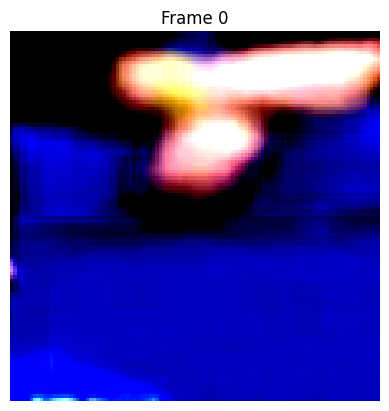

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


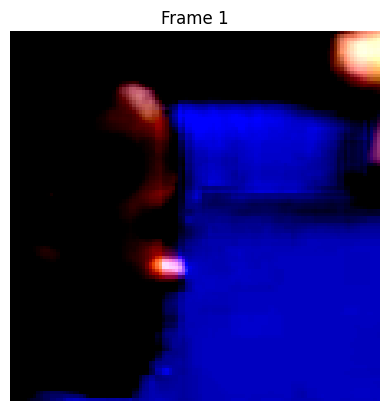

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


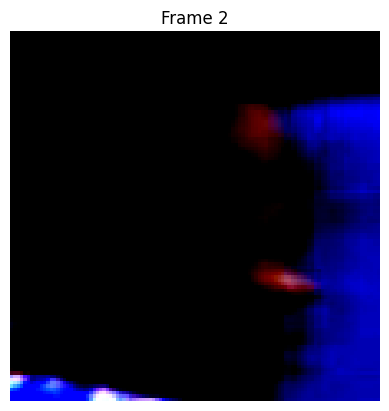

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


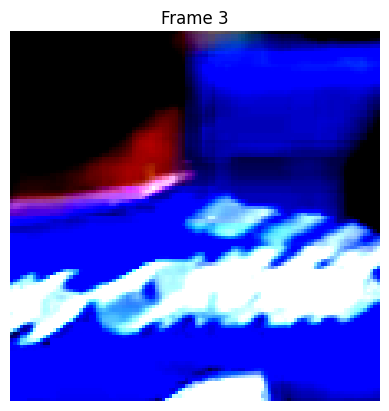

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


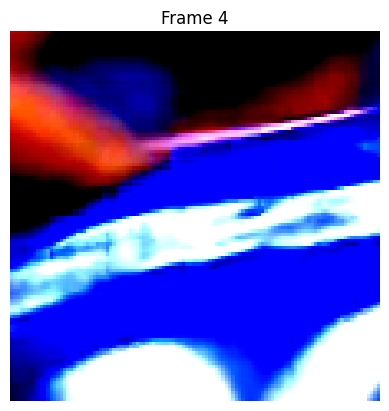

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


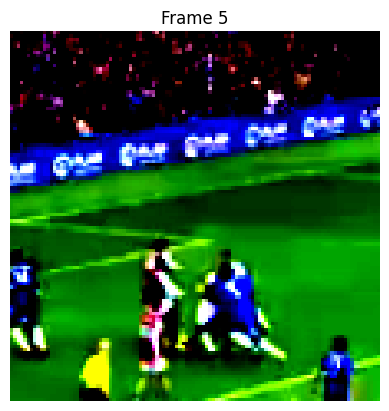

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


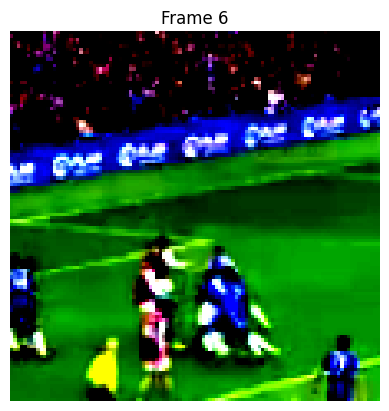

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


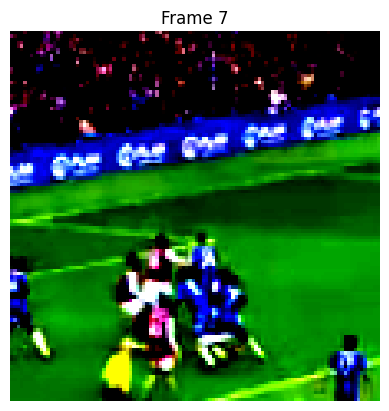

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


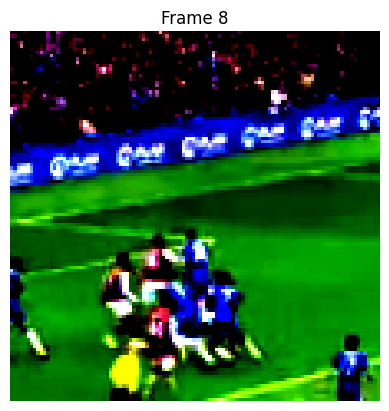

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


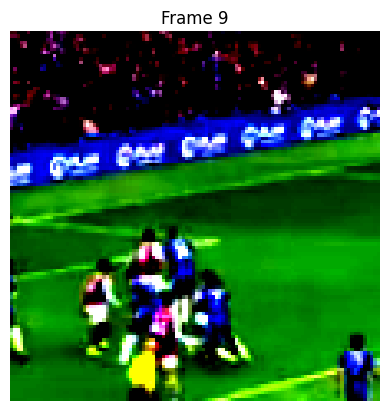

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


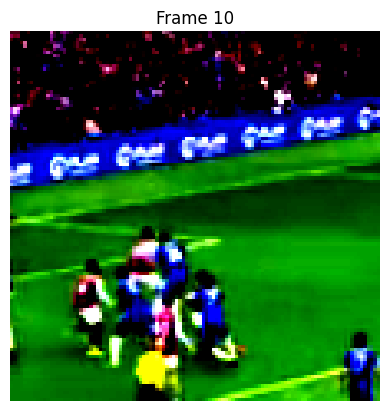

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


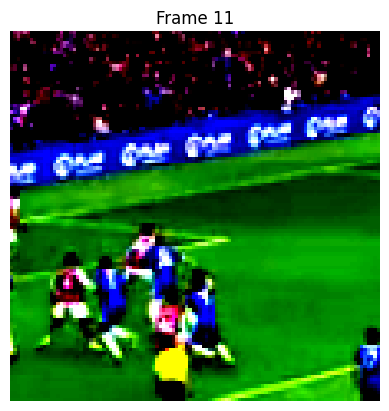

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


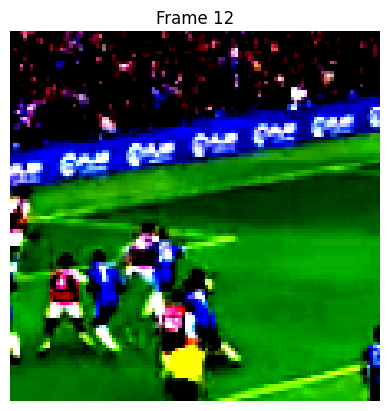

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


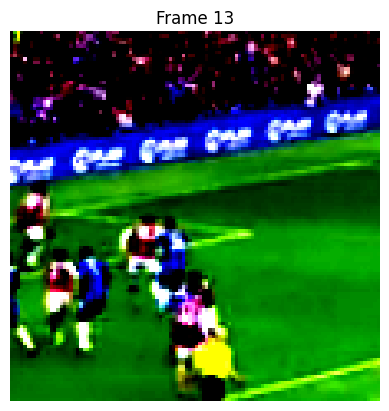

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


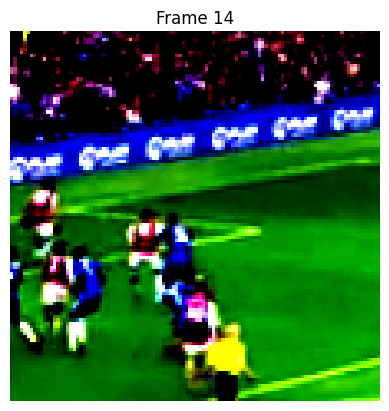

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


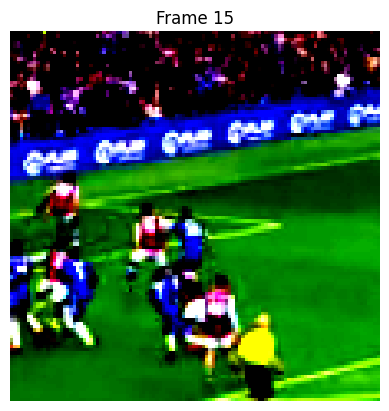

In [13]:
import matplotlib.pyplot as plt
import time

# x1 tiene forma (3, 16, 224, 224)
for t in range(x1.shape[1]):  # recorre los 16 frames
    frame = x1[:, t, :, :].permute(1, 2, 0)  # cambia a (H, W, C)
    plt.imshow(frame)
    plt.title(f"Frame {t}")
    plt.axis("off")
    plt.show()
    time.sleep(0.2)  # pausa breve entre frames


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
import torchvision
import torch
from torch import nn
PRETRAINED = True 
def build_model(num_classes=8, pretrained=PRETRAINED):
    try:
        weights = torchvision.models.video.R2Plus1D_18_Weights.KINETICS400_V1 if pretrained else None
    except:
        weights = None
    model = torchvision.models.video.r2plus1d_18(weights=weights).to(device)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

In [16]:
model = build_model().to(device)

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:00<00:00, 174MB/s]  


In [17]:
!pip install torchinfo

In [16]:
from torchinfo import summary
summary(model, input_size=(1, 3, 16, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
VideoResNet                                   [1, 8]                    --
├─R2Plus1dStem: 1-1                           [1, 64, 16, 112, 112]     --
│    └─Conv3d: 2-1                            [1, 45, 16, 112, 112]     6,615
│    └─BatchNorm3d: 2-2                       [1, 45, 16, 112, 112]     90
│    └─ReLU: 2-3                              [1, 45, 16, 112, 112]     --
│    └─Conv3d: 2-4                            [1, 64, 16, 112, 112]     8,640
│    └─BatchNorm3d: 2-5                       [1, 64, 16, 112, 112]     128
│    └─ReLU: 2-6                              [1, 64, 16, 112, 112]     --
├─Sequential: 1-2                             [1, 64, 16, 112, 112]     --
│    └─BasicBlock: 2-7                        [1, 64, 16, 112, 112]     --
│    │    └─Sequential: 3-1                   [1, 64, 16, 112, 112]     111,008
│    │    └─Sequential: 3-2                   [1, 64, 16, 112, 112]     111,008
│  

In [18]:
NUM_CLASSES = 8

In [19]:
def compute_class_weights_from_df(df):
    counts = df["class_id"].value_counts().reindex(range(NUM_CLASSES), fill_value=0).values.astype(np.float32)
    counts = np.maximum(counts, 1.0)
    inv = 1.0 / counts
    inv = inv / inv.sum() * len(inv)
    return torch.tensor(inv, dtype=torch.float32)

# # -------------------------
# # 3) Epoch train/val
# # -------------------------
# def train_one_epoch(model, loader, optimizer, criterion, epoch, grad_clip=1.0):
#     model.train()
#     scaler = torch.cuda.amp.GradScaler(enabled=True)
#     loss_sum = 0.0
#     y_true, y_pred = [], []

#     pbar = tqdm(loader, desc=f"Train {epoch}", leave=False)
#     for x, y in pbar:
#         x = x.to(device, non_blocking=True)
#         y = y.to(device, non_blocking=True)

#         optimizer.zero_grad(set_to_none=True)
#         with torch.cuda.amp.autocast(enabled=True):
#             logits = model(x)           # [B, C]
#             loss = criterion(logits, y)

#         scaler.scale(loss).backward()
#         if grad_clip is not None and grad_clip > 0:
#             scaler.unscale_(optimizer)
#             torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
#         scaler.step(optimizer)
#         scaler.update()

#         loss_sum += loss.item() * x.size(0)
#         y_true.extend(y.detach().cpu().tolist())
#         y_pred.extend(logits.argmax(1).detach().cpu().tolist())

#     avg_loss = loss_sum / len(loader.dataset)
#     macro = f1_score(y_true, y_pred, average="macro")
#     micro = f1_score(y_true, y_pred, average="micro")
#     acc   = accuracy_score(y_true, y_pred)
#     return avg_loss, macro, micro, acc

# @torch.no_grad()
# def evaluate(model, loader, criterion, name="VAL", print_report=True):
#     model.eval()
#     loss_sum = 0.0
#     y_true, y_pred = [], []

#     for x, y in tqdm(loader, desc=f"{name}", leave=False):
#         x = x.to(device, non_blocking=True)
#         y = y.to(device, non_blocking=True)
#         with torch.cuda.amp.autocast(enabled=True):
#             logits = model(x)
#             loss = criterion(logits, y)
#         loss_sum += loss.item() * x.size(0)
#         y_true.extend(y.detach().cpu().tolist())
#         y_pred.extend(logits.argmax(1).detach().cpu().tolist())

#     avg_loss = loss_sum / len(loader.dataset)
#     macro = f1_score(y_true, y_pred, average="macro")
#     micro = f1_score(y_true, y_pred, average="micro")
#     acc   = accuracy_score(y_true, y_pred)

#     if print_report:
#         print(f"\n== {name} REPORT ==")
#         print(classification_report(y_true, y_pred, target_names=CLASS_LABELS, digits=3))

#     return avg_loss, macro, micro, acc

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, accuracy_score, classification_report


@torch.no_grad()
def _validate_epoch(model, val_loader, criterion, device, amp_enabled=True, epoch=0):
    model.eval()
    va_loss_sum = 0.0
    va_true, va_pred = [], []


    for x, y in tqdm(
        val_loader, desc=f"VAL {epoch}", leave=True, position=1, dynamic_ncols=True
    ):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.amp.autocast('cuda', enabled=amp_enabled):
            logits = model(x)
            loss = criterion(logits, y)

        va_loss_sum += loss.item() * x.size(0)
        va_true.extend(y.detach().cpu().tolist())
        va_pred.extend(logits.argmax(1).detach().cpu().tolist())

    va_avg_loss = va_loss_sum / len(val_loader.dataset)
    va_macro = f1_score(va_true, va_pred, average="macro")
    va_micro = f1_score(va_true, va_pred, average="micro")
    va_acc   = accuracy_score(va_true, va_pred)
    val_stats = {
        "loss": va_avg_loss,
        "macro_f1": va_macro,
        "micro_f1": va_micro,
        "acc": va_acc,
        "y_true": va_true,
        "y_pred": va_pred,
    }
    return val_stats


def train_validate_epoch(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epoch,
    device,
    grad_clip: float = 1.0,
    amp_enabled: bool = True,
    print_val_report: bool = False,
    class_names=None,  
):
    """
    Corre una época completa: TRAIN + VALIDATION.
    Retorna:
      train_stats = {"loss","macro_f1","micro_f1","acc"}
      val_stats   = {"loss","macro_f1","micro_f1","acc","y_true","y_pred"}
    """

    # =================== TRAIN ===================
    model.train()
    scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)

    tr_loss_sum = 0.0
    tr_true, tr_pred = [], []

    pbar = tqdm(
        train_loader, desc=f"Train {epoch}", leave=True, position=1, dynamic_ncols=True
    )
    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=amp_enabled):
            logits = model(x)             # [B, C]
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        if grad_clip is not None and grad_clip > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        tr_loss_sum += loss.item() * x.size(0)
        tr_true.extend(y.detach().cpu().tolist())
        tr_pred.extend(logits.argmax(1).detach().cpu().tolist())

    tr_avg_loss = tr_loss_sum / len(train_loader.dataset)
    tr_macro = f1_score(tr_true, tr_pred, average="macro")
    tr_micro = f1_score(tr_true, tr_pred, average="micro")
    tr_acc   = accuracy_score(tr_true, tr_pred)
    train_stats = {
        "loss": tr_avg_loss,
        "macro_f1": tr_macro,
        "micro_f1": tr_micro,
        "acc": tr_acc,
    }


    val_stats = _validate_epoch(
        model, val_loader, criterion, device, amp_enabled=amp_enabled, epoch=epoch
    )

    if print_val_report:
        # Evita que tqdm borre el reporte
        tqdm.write("\n== VAL REPORT ==")
        try:
            tqdm.write(classification_report(
                val_stats["y_true"], val_stats["y_pred"],
                target_names=class_names, digits=3
            ))
        except Exception:
            tqdm.write(classification_report(
                val_stats["y_true"], val_stats["y_pred"], digits=3
            ))


    tqdm.write(
        f"Epoch {epoch:02d} | "
        f"Train: loss {tr_avg_loss:.4f} | mF1 {tr_macro:.4f} | acc {tr_acc:.4f} || "
        f"Val: loss {val_stats['loss']:.4f} | mF1 {val_stats['macro_f1']:.4f} | acc {val_stats['acc']:.4f}"
    )

    # Limpio los vectores grandes para no acumular memoria fuera
    val_stats.pop("y_true", None)
    val_stats.pop("y_pred", None)

    return train_stats, val_stats


def run_training(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device="cuda",
    num_epochs=10,
    amp_enabled=True,
    scheduler=None,      # opcional: StepLR / CosineAnnealing / etc.
    class_names=None,
):
    model.to(device)
    history = []

    for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs", position=0, leave=True):
        tr, va = train_validate_epoch(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            criterion=criterion,
            epoch=epoch,
            device=device,
            grad_clip=1.0,
            amp_enabled=amp_enabled,
            print_val_report=False,
            class_names=class_names,
        )

        if scheduler is not None:
            try:
                scheduler.step(va["loss"])
            except TypeError:
                scheduler.step()

        history.append({"epoch": epoch, "train": tr, "val": va})

    return history

In [ ]:
lr = 1e-4
weight_decay = 1e-4
epochs = 10

class_weights = compute_class_weights_from_df(df_train).to(device)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr,
    weight_decay=weight_decay,
)
criterion = nn.CrossEntropyLoss(weight=class_weights)

history = run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=epochs,
    amp_enabled=True,     # para mixed precision
)

# Mostrar última época
print("Última época:", history[-1])

import json
with open("training_history.json", "w") as f:
    json.dump(history, f, indent=2)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 01 | Train: loss 1.2380 | mF1 0.4677 | acc 0.5265 || Val: loss 1.0791 | mF1 0.4981 | acc 0.5644


Train 2:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 02 | Train: loss 0.8232 | mF1 0.6442 | acc 0.6978 || Val: loss 0.9862 | mF1 0.6003 | acc 0.6479


Train 3:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 03 | Train: loss 0.6287 | mF1 0.7366 | acc 0.7731 || Val: loss 0.9261 | mF1 0.6087 | acc 0.6844


Train 4:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 04 | Train: loss 0.4622 | mF1 0.8031 | acc 0.8171 || Val: loss 1.0583 | mF1 0.6107 | acc 0.6987


Train 5:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 05 | Train: loss 0.3166 | mF1 0.8650 | acc 0.8689 || Val: loss 1.2103 | mF1 0.6354 | acc 0.7417


Train 6:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 6:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e81121b27a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e81121b27a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 06 | Train: loss 0.2347 | mF1 0.9016 | acc 0.8992 || Val: loss 1.1709 | mF1 0.6700 | acc 0.7345


Train 7:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 07 | Train: loss 0.2034 | mF1 0.9130 | acc 0.9223 || Val: loss 1.5114 | mF1 0.6221 | acc 0.7401


Train 8:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 08 | Train: loss 0.1683 | mF1 0.9300 | acc 0.9334 || Val: loss 1.4408 | mF1 0.6265 | acc 0.7273


Train 9:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 09 | Train: loss 0.1286 | mF1 0.9504 | acc 0.9493 || Val: loss 1.6183 | mF1 0.6538 | acc 0.7758


Train 10:   0%|          | 0/382 [00:00<?, ?it/s]

VAL 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 | Train: loss 0.1052 | mF1 0.9581 | acc 0.9575 || Val: loss 1.7439 | mF1 0.6468 | acc 0.7512
Última época: {'epoch': 10, 'train': {'loss': 0.10516037299379595, 'macro_f1': 0.9580502377159346, 'micro_f1': 0.9574607329842932, 'acc': 0.9574607329842932}, 'val': {'loss': 1.743869001635118, 'macro_f1': 0.6467971939930046, 'micro_f1': 0.7511923688394276, 'acc': 0.7511923688394276}}


In [23]:
torch.save(model.state_dict(), "modelo.pth")

In [24]:
import torch
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, accuracy_score, classification_report

@torch.no_grad()
def test_model(model, test_loader, criterion, device, amp_enabled=True, class_names=None):
    model.eval()
    test_loss_sum = 0.0
    y_true, y_pred = [], []

    for x, y in tqdm(test_loader, desc="Testing", dynamic_ncols=True, leave=True):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.amp.autocast('cuda', enabled=amp_enabled):
            logits = model(x)
            loss = criterion(logits, y)

        test_loss_sum += loss.item() * x.size(0)
        y_true.extend(y.detach().cpu().tolist())
        y_pred.extend(logits.argmax(1).detach().cpu().tolist())

    # Métricas globales
    avg_loss = test_loss_sum / len(test_loader.dataset)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    micro_f1 = f1_score(y_true, y_pred, average="micro")
    acc      = accuracy_score(y_true, y_pred)

    print("\n=== TEST RESULTS ===")
    print(f"Loss: {avg_loss:.4f} | Macro-F1: {macro_f1:.4f} | Micro-F1: {micro_f1:.4f} | Acc: {acc:.4f}")

    if class_names is not None:
        print("\n--- Classification Report ---")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
    else:
        print("\n--- Classification Report ---")
        print(classification_report(y_true, y_pred, digits=3))

    return {
        "loss": avg_loss,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "acc": acc,
        "y_true": y_true,
        "y_pred": y_pred,
    }


In [25]:
test_stats = test_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    amp_enabled=True,
)

Testing:   0%|          | 0/84 [00:00<?, ?it/s]


=== TEST RESULTS ===
Loss: 1.8489 | Macro-F1: 0.6455 | Micro-F1: 0.7647 | Acc: 0.7647

--- Classification Report ---
              precision    recall  f1-score   support

           0      0.798     0.901     0.846       575
           1      0.748     0.837     0.790       263
           2      0.727     0.584     0.647       173
           3      0.603     0.553     0.577        85
           4      0.823     0.750     0.785        68
           5      0.800     0.311     0.448        90
           6      0.250     0.250     0.250        16
           7      0.842     0.800     0.821        60

    accuracy                          0.765      1330
   macro avg      0.699     0.623     0.645      1330
weighted avg      0.763     0.765     0.754      1330



In [26]:
print(test_stats["macro_f1"], test_stats["acc"])

0.6454503234903246 0.7646616541353384
